## Import libraries

In [1]:
! pip install -U sentence-transformers

     |████████████████████████████████| 74 kB 626 kB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.0.3-py3-none-any.whl size=114276 sha256=d59f53d65d1670458018309531a1d383c036781e4c9f9d472f99d7d16256fe0a
  Stored in directory: /root/.cache/pip/wheels/1b/bf/4c/23bc3e6ee5cce3844a3a807d26c7943caafa756a44574d7aa1
Successfully built sentence-transformers


In [2]:
import pickle
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import QuantileTransformer

In [3]:
roberta_embedder = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

  0%|          | 0.00/461M [00:00<?, ?B/s]

## Load source datasets

In [4]:
train_df = pd.read_csv('../input/workation-price-prediction/Participant_Data_WPPH/Train.csv')
test_df = pd.read_csv('../input/workation-price-prediction/Participant_Data_WPPH/Test.csv')
print("train_df: {} \ntest_df: {}".format(train_df.shape, test_df.shape))

train_df: (21000, 15) 
test_df: (9000, 14)


In [5]:
train_df = train_df[train_df['Cancellation Rules'] != 'Packages will be escorted by Local Representative of the Vendor on the day of Full or Half day tours as per itinerary.Vendor Representative are English speaking &  Explain about the Tours in English Language Only. Package has the flexibility to add extra Nights before start of the Tour and at the end of the tour. Please contact MMT representative.Package has the flexibility to add extra Optional tours within the itinerary subject to time availability in each Package. Please contact MMT representative.Price of the Holiday Services are calculated per passenger on twin-sharing basis.The taxes mentioned are taxes as applicable on September 1st, 2017. In the event of increase in the rate of taxation, the differential amount will be payable by the customer. A surcharge may be applicable for certain departures.Service tax charges will apply, as applicable.Cost of deviation and cost of extension of the validity on your ticket is not included.Porter fees at hotels, airports and seaports is not included in the Holiday Services and has to be borne by the customer.Cost of expenses of personal nature such as, laundry, telephone calls, room service, alcoholic beverages, mini bar etc., are not included.Any other items not mentioned in the Inclusions list are not included in the cost of the Holiday Services.Prices are dynamic and based on offers running at the time of booking. MMT reserves the right to change prices at any time.In case the selected hotel is unavailable for booking, an alternate arrangement will be offered to the customer in a hotel of similar category.Due to operational reasons, the routing of this holiday may be amended. However, all mentioned services will remain unchanged.Pricing of the Holiday Services is based on the age of the passengers. Please make sure you enter it correctly at the time of booking. Furnishing wrong passenger age may incur penalty at a later stage.'].copy()
train_df = train_df[train_df['Cancellation Rules'] != "Price of the booking is calculated for per passenger on a twin-sharing basis. Prices are dynamic and may be based on offers running at the time of booking. MMT reserves the right to change prices at any time.Pricing of the booking is based on the age of the passengers. Please make sure you enter the correct age of passengers at the time of booking. Passengers furnishing incorrect age details may incur penalty at the time of travelling.A surcharge may be applicable for certain departures. In case the selected hotel is unavailable for booking, an alternate arrangement will be offered to the customer in another hotel of a similar category.Due to operational reasons, the routing of this tour may be amended. However, all mentioned services will remain unchanged.Cost of deviation and cost of extension of the validity on your ticket is not included.Porter fee at hotels, airports and seaports is not included in the package and has to be borne by the customer.Cost of expenses of personal nature such as, laundry, telephone calls, room service, alcoholic beverages, mini bar etc., are not included.Any other items not mentioned under ?Inclusions? are not included in the cost of the booking.Package price does not include Gala dinner charges applicable on Christmas and New Year's Eve"].copy()
print("train_df: {} \ntest_df: {}".format(train_df.shape, test_df.shape))

train_df: (20998, 15) 
test_df: (9000, 14)


## Extract target label

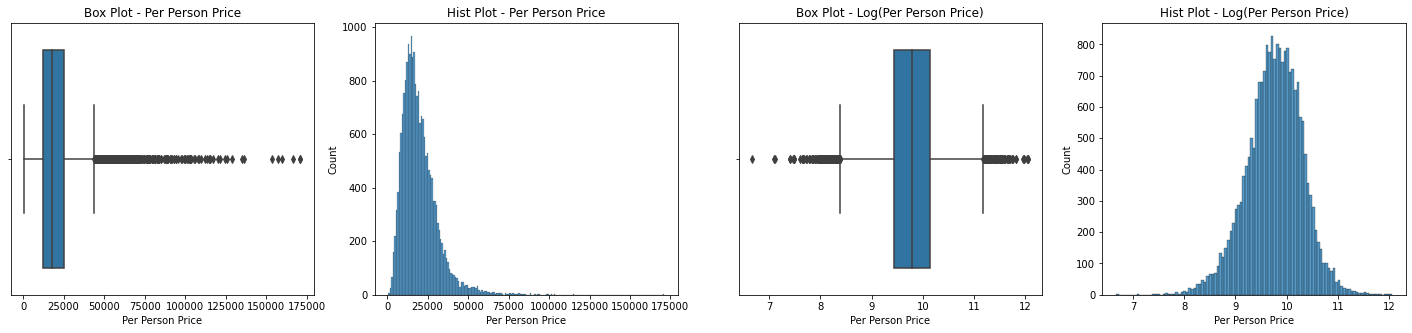

In [6]:
x1 = train_df['Per Person Price']
y1 = np.log1p(train_df['Per Person Price'])

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0])
sns.histplot(x=x1, ax=ax[1])
sns.boxplot(x=y1, ax=ax[2])
sns.histplot(x=y1, ax=ax[3])
ax[0].title.set_text('Box Plot - Per Person Price')
ax[1].title.set_text('Hist Plot - Per Person Price')
ax[2].title.set_text('Box Plot - Log(Per Person Price)')
ax[3].title.set_text('Hist Plot - Log(Per Person Price)')

In [7]:
train_y = np.log1p(train_df['Per Person Price'])
train_df.drop(['Per Person Price'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))

train_y: (20998,)


## Feature Engineering

### Combine train/test datasets

In [8]:
combined_df = train_df.append(test_df, sort=False, ignore_index=True)
print(combined_df.shape)

(29998, 14)


### Package Name

In [9]:
def remove_punctuations(text):
    punct =[]
    punct += list(string.punctuation)
    punct += '’'
    punct += '-'
    punct.remove("'")
    
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

In [10]:
def process_pkg_nm(df):
    df['Package Name'] = df['Package Name'].apply(lambda x: x.lower())
    df['Package Name'] = df['Package Name'].apply(lambda x: x.replace('\n', ' '))
    df['Package Name'] = df['Package Name'].str.replace('http\S+|www.\S+', '', case=False)
    df['Package Name'] = df['Package Name'].apply(lambda x: x.replace('&gt;', ''))
    df['Package Name'] = df['Package Name'].apply(remove_punctuations)
    df['Package Name'] = df['Package Name'].apply(lambda x: str(x).replace(" s ", " "))
    return df

In [11]:
combined_df = process_pkg_nm(combined_df)
combined_df.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...


In [12]:
roberta_sentence_embeddings = roberta_embedder.encode(combined_df['Package Name'].values.tolist(), 
                                                      batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

In [13]:
combined_df.set_index('Uniq Id', inplace=True)
col_list = ['pkg_embed_'+str(i) for i in range(roberta_sentence_embeddings.shape[1])]
features_df = pd.DataFrame(roberta_sentence_embeddings, 
                           columns=col_list,
                           index=combined_df.index)
print("features_df: {}".format(features_df.shape))
combined_df = pd.merge(combined_df, features_df, 
                       on='Uniq Id', sort=False)
combined_df.reset_index(inplace=True)
combined_df.head()

features_df: (29998, 768)


,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,pkg_embed_758,pkg_embed_759,pkg_embed_760,pkg_embed_761,pkg_embed_762,pkg_embed_763,pkg_embed_764,pkg_embed_765,pkg_embed_766,pkg_embed_767
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,...,0.085819,-0.328793,-1.079112,0.853173,-0.963321,-0.004071,0.137176,-0.655783,0.291813,-0.104752
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,...,-0.990715,0.584701,-2.134777,0.215331,-1.146065,0.351020,-0.006408,-0.383575,0.228855,0.323902
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,...,-0.911386,0.305805,-0.831533,0.837408,-0.405936,0.338174,-0.147642,-0.295419,0.512122,0.201887
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,...,0.052282,0.670423,-0.994780,0.321510,1.262110,0.034494,-1.202341,-1.259806,0.382396,0.632984
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,...,1.148140,-0.491759,-0.448640,0.240398,-0.793073,0.438602,-0.459168,-0.527704,-0.006230,0.215611


### Package Type

In [14]:
package_map = {
    'Budget': 0,
    'Standard': 1,
    'Luxury': 2,
    'Deluxe': 3,
    'Premium': 4
}

combined_df['Package Type'] = combined_df['Package Type'].map(package_map)

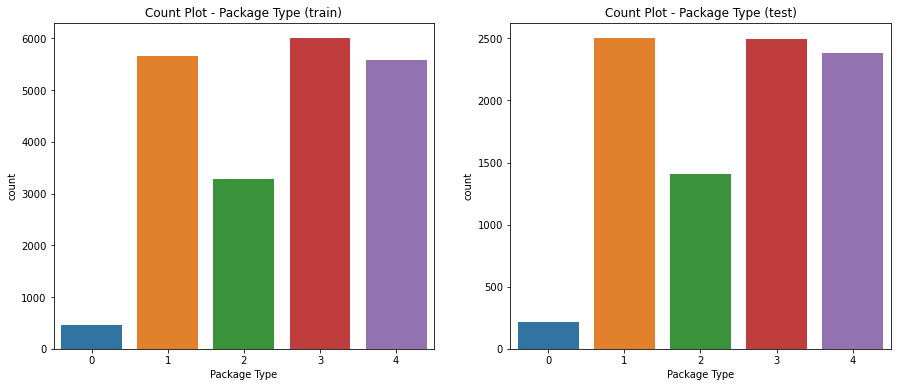

In [15]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='Package Type', data=combined_df[:train_y.shape[0]], ax=ax[0])
sns.countplot(x='Package Type', data=combined_df[train_y.shape[0]:], ax=ax[1])
ax[0].title.set_text('Count Plot - Package Type (train)')
ax[1].title.set_text('Count Plot - Package Type (test)')

### Destination

In [16]:
combined_df['Destination_Count'] = combined_df['Destination'].apply(lambda x: len(x.split('|')))
print("combined_df: {}".format(combined_df.shape))
combined_df.head()

combined_df: (29998, 783)


,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,pkg_embed_759,pkg_embed_760,pkg_embed_761,pkg_embed_762,pkg_embed_763,pkg_embed_764,pkg_embed_765,pkg_embed_766,pkg_embed_767,Destination_Count
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,1,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,...,-0.328793,-1.079112,0.853173,-0.963321,-0.004071,0.137176,-0.655783,0.291813,-0.104752,4
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,4,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,...,0.584701,-2.134777,0.215331,-1.146065,0.351020,-0.006408,-0.383575,0.228855,0.323902,3
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,2,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,...,0.305805,-0.831533,0.837408,-0.405936,0.338174,-0.147642,-0.295419,0.512122,0.201887,2
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,4,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,...,0.670423,-0.994780,0.321510,1.262110,0.034494,-1.202341,-1.259806,0.382396,0.632984,4
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,4,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,...,-0.491759,-0.448640,0.240398,-0.793073,0.438602,-0.459168,-0.527704,-0.006230,0.215611,2


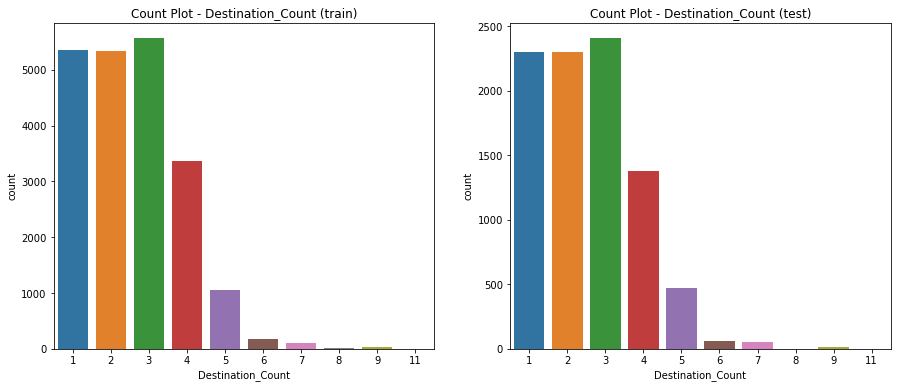

In [17]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='Destination_Count', data=combined_df[:train_y.shape[0]], ax=ax[0])
sns.countplot(x='Destination_Count', data=combined_df[train_y.shape[0]:], ax=ax[1])
ax[0].title.set_text('Count Plot - Destination_Count (train)')
ax[1].title.set_text('Count Plot - Destination_Count (test)')

In [18]:
def process_dest(df):
    df['Destination'] = df['Destination'].apply(lambda x: x.lower())
    df['Destination'] = df['Destination'].apply(lambda x: x.replace('\n', ' '))
    df['Destination'] = df['Destination'].str.replace('http\S+|www.\S+', '', case=False)
    df['Destination'] = df['Destination'].apply(lambda x: x.replace('&gt;', ''))
    df['Destination'] = df['Destination'].apply(remove_punctuations)
    df['Destination'] = df['Destination'].apply(lambda x: str(x).replace(" s ", " "))
    return df

In [19]:
combined_df = process_dest(combined_df)
combined_df.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,pkg_embed_759,pkg_embed_760,pkg_embed_761,pkg_embed_762,pkg_embed_763,pkg_embed_764,pkg_embed_765,pkg_embed_766,pkg_embed_767,Destination_Count
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,1,new delhi shimla manali chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,...,-0.328793,-1.079112,0.853173,-0.963321,-0.004071,0.137176,-0.655783,0.291813,-0.104752,4
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,4,srinagar pahalgam srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,...,0.584701,-2.134777,0.215331,-1.146065,0.351020,-0.006408,-0.383575,0.228855,0.323902,3
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,2,udaipur chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,...,0.305805,-0.831533,0.837408,-0.405936,0.338174,-0.147642,-0.295419,0.512122,0.201887,2
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,4,munnar kumarakom allepey kovalam and poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,...,0.670423,-0.994780,0.321510,1.262110,0.034494,-1.202341,-1.259806,0.382396,0.632984,4
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,4,pattaya bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,...,-0.491759,-0.448640,0.240398,-0.793073,0.438602,-0.459168,-0.527704,-0.006230,0.215611,2


In [20]:
roberta_sentence_embeddings = roberta_embedder.encode(combined_df['Destination'].values.tolist(), 
                                                      batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

In [21]:
combined_df.set_index('Uniq Id', inplace=True)
col_list = ['dest_embed_'+str(i) for i in range(roberta_sentence_embeddings.shape[1])]
features_df = pd.DataFrame(roberta_sentence_embeddings, 
                           columns=col_list,
                           index=combined_df.index)
print("features_df: {}".format(features_df.shape))
combined_df = pd.merge(combined_df, features_df, 
                       on='Uniq Id', sort=False)
combined_df.reset_index(inplace=True)
combined_df.head()

features_df: (29998, 768)


,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,dest_embed_758,dest_embed_759,dest_embed_760,dest_embed_761,dest_embed_762,dest_embed_763,dest_embed_764,dest_embed_765,dest_embed_766,dest_embed_767
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,1,new delhi shimla manali chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,...,-0.152476,-0.506776,-0.570818,0.108449,-0.149125,-0.099692,-0.366415,-0.870146,-0.116778,-0.388993
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,4,srinagar pahalgam srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,...,-0.549929,-0.069633,-1.090731,0.402718,-0.272768,0.720583,-0.932234,-0.577475,0.309618,0.004971
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,2,udaipur chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,...,0.254212,-0.066697,-1.043035,0.152819,-0.387730,0.694549,-0.961470,0.026484,0.171974,-0.064850
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,4,munnar kumarakom allepey kovalam and poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,...,-0.274989,0.072395,-0.450023,-0.519155,0.428749,0.240476,-0.161582,-0.207768,0.299334,-0.104545
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,4,pattaya bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,...,1.604817,-0.123808,-0.470475,0.287655,-0.092461,0.258074,-0.987259,-0.151094,0.163280,0.095479


### Itinerary

In [22]:
combined_df['total_days'] = 0

for idx in tqdm(range(combined_df.shape[0])):
    item1 = combined_df.iloc[idx]['Itinerary']
    total_days = 0
    for item2 in item1.split(' . '):
        days, city = item2.split(' ', 1)
        days = int(days.replace('N',''))
        if city not in combined_df.columns.to_list():
            combined_df[city] = 0
        
        total_days += days
        combined_df.loc[idx, city] = days
    
    combined_df.loc[idx, 'total_days'] = total_days

print("combined_df: {}".format(combined_df.shape))
combined_df.head()

100%|██████████| 29998/29998 [01:35<00:00, 313.38it/s]

combined_df: (29998, 1734)


,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,Vadodara,Joshimath,Copenhagen,Daman,Helsinki,Gwalior,Orchha,Khajuraho,Alwar,Oslo
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,1,new delhi shimla manali chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,...,0,0,0,0,0,0,0,0,0,0
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,4,srinagar pahalgam srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,...,0,0,0,0,0,0,0,0,0,0
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,2,udaipur chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,...,0,0,0,0,0,0,0,0,0,0
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,4,munnar kumarakom allepey kovalam and poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,...,0,0,0,0,0,0,0,0,0,0
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,4,pattaya bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,...,0,0,0,0,0,0,0,0,0,0


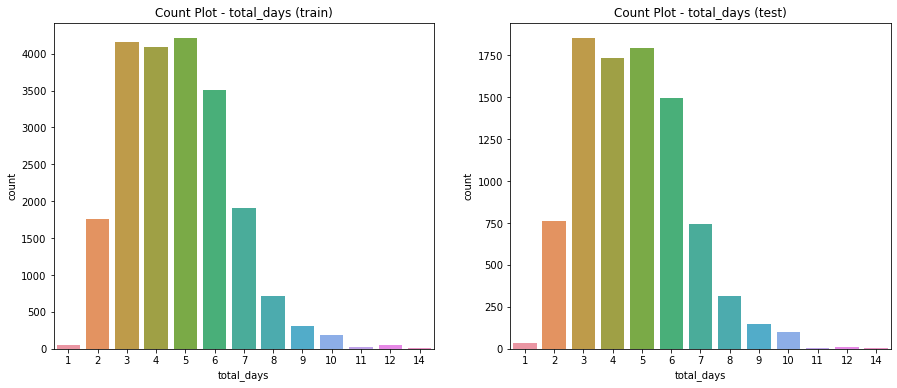

In [23]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='total_days', data=combined_df[:train_y.shape[0]], ax=ax[0])
sns.countplot(x='total_days', data=combined_df[train_y.shape[0]:], ax=ax[1])
ax[0].title.set_text('Count Plot - total_days (train)')
ax[1].title.set_text('Count Plot - total_days (test)')

### Travel Date

In [24]:
combined_df['travel_date_year'] = combined_df['Travel Date'].map(lambda x: pd.to_datetime(x).year)
combined_df['travel_date_quarter'] = combined_df['Travel Date'].map(lambda x: pd.to_datetime(x).quarter)
combined_df['travel_date_month'] = combined_df['Travel Date'].map(lambda x: pd.to_datetime(x).month)
combined_df['travel_date_week'] = combined_df['Travel Date'].map(lambda x: pd.to_datetime(x).week)
combined_df['travel_date_day_year'] = combined_df['Travel Date'].map(lambda x: pd.to_datetime(x).dayofyear)
combined_df['travel_date_day_month'] = combined_df['Travel Date'].map(lambda x: pd.to_datetime(x).day)
combined_df['travel_date_day_week'] = combined_df['Travel Date'].map(lambda x: pd.to_datetime(x).dayofweek)
combined_df['travel_date_day_weekend'] = np.where(combined_df['travel_date_day_week'].isin([5,6]),1,0)
combined_df.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,Alwar,Oslo,travel_date_year,travel_date_quarter,travel_date_month,travel_date_week,travel_date_day_year,travel_date_day_month,travel_date_day_week,travel_date_day_weekend
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,1,new delhi shimla manali chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,...,0,0,2021,3,7,30,211,30,4,0
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,4,srinagar pahalgam srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,...,0,0,2021,3,8,32,224,12,3,0
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,2,udaipur chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,...,0,0,2021,2,4,17,116,26,0,0
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,4,munnar kumarakom allepey kovalam and poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,...,0,0,2021,3,8,34,239,27,4,0
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,4,pattaya bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,...,0,0,2021,4,12,49,346,12,6,1


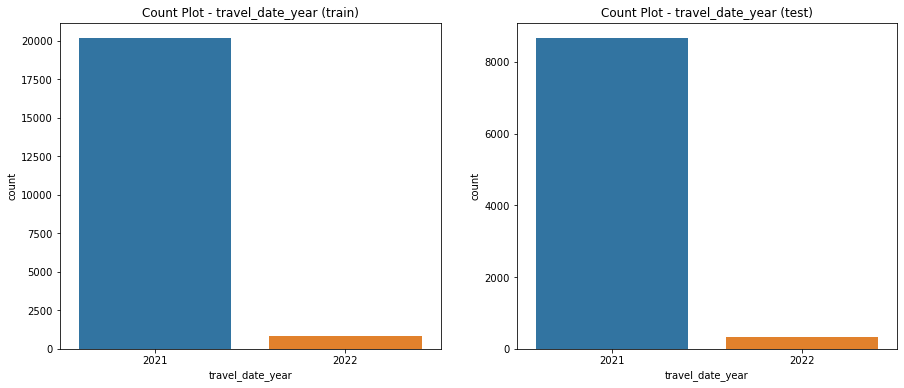

In [25]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='travel_date_year', data=combined_df[:train_y.shape[0]], ax=ax[0])
sns.countplot(x='travel_date_year', data=combined_df[train_y.shape[0]:], ax=ax[1])
ax[0].title.set_text('Count Plot - travel_date_year (train)')
ax[1].title.set_text('Count Plot - travel_date_year (test)')

### Hotel Details

In [26]:
combined_df['total_hotels'] = 0
str_replace_dict = {
    '': 0,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5
}

for idx in tqdm(range(combined_df.shape[0])):
    item1 = combined_df.iloc[idx]['Hotel Details']
    if item1 != 'Not Available':
        hotel_list = []
        for item2 in item1.split('|'):
            hotel, rating = item2.rsplit(':',1)
            hotel_list.append(hotel)
            if hotel not in combined_df.columns.to_list():
                combined_df[hotel] = 0
            
            if rating in ['Three','Five','Two','Four','']:
                rating = str_replace_dict[rating]
            
            combined_df.loc[idx, hotel] = float(rating)
        
        combined_df.loc[idx, 'total_hotels'] = len(list(set(hotel_list)))
        combined_df.loc[idx, 'hotels_list'] = '|'.join(list(set(hotel_list)))

combined_df["hotels_list"].fillna("Not Available", inplace=True)
print("combined_df: {}".format(combined_df.shape))
combined_df.head()

100%|██████████| 29998/29998 [05:52<00:00, 84.99it/s] 

combined_df: (29998, 3142)


,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,Udechee Huts,Regenta Central Herald,Quest Abbotsford,Oriental Residency,IBIS Nashik - An AccorHotels Brand,Shilpi Hill Resort,Sandy Resort,Kaizun Bed and Breakfast,Seven Terraces,Summer Sands Beach Resort-MMT Holidays Special
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,1,new delhi shimla manali chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,4,srinagar pahalgam srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,2,udaipur chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,4,munnar kumarakom allepey kovalam and poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,4,pattaya bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0


In [27]:
def process_hotel_nm(df):
    df['hotels_list'] = df['hotels_list'].apply(lambda x: x.lower())
    df['hotels_list'] = df['hotels_list'].apply(lambda x: x.replace('\n', ' '))
    df['hotels_list'] = df['hotels_list'].str.replace('http\S+|www.\S+', '', case=False)
    df['hotels_list'] = df['hotels_list'].apply(lambda x: x.replace('&gt;', ''))
    df['hotels_list'] = df['hotels_list'].apply(remove_punctuations)
    df['hotels_list'] = df['hotels_list'].apply(lambda x: str(x).replace(" s ", " "))
    return df

In [28]:
combined_df = process_hotel_nm(combined_df)
combined_df.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,Udechee Huts,Regenta Central Herald,Quest Abbotsford,Oriental Residency,IBIS Nashik - An AccorHotels Brand,Shilpi Hill Resort,Sandy Resort,Kaizun Bed and Breakfast,Seven Terraces,Summer Sands Beach Resort-MMT Holidays Special
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,1,new delhi shimla manali chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,4,srinagar pahalgam srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,2,udaipur chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,4,munnar kumarakom allepey kovalam and poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,4,pattaya bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0


In [29]:
roberta_sentence_embeddings = roberta_embedder.encode(combined_df['hotels_list'].values.tolist(), 
                                                      batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

In [30]:
combined_df.set_index('Uniq Id', inplace=True)
col_list = ['hotel_embed_'+str(i) for i in range(roberta_sentence_embeddings.shape[1])]
features_df = pd.DataFrame(roberta_sentence_embeddings, 
                           columns=col_list,
                           index=combined_df.index)
print("features_df: {}".format(features_df.shape))
combined_df = pd.merge(combined_df, features_df, 
                       on='Uniq Id', sort=False)
combined_df.reset_index(inplace=True)
combined_df.head()

features_df: (29998, 768)


,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,hotel_embed_758,hotel_embed_759,hotel_embed_760,hotel_embed_761,hotel_embed_762,hotel_embed_763,hotel_embed_764,hotel_embed_765,hotel_embed_766,hotel_embed_767
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,1,new delhi shimla manali chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,...,0.040308,0.251682,-0.860310,0.189461,-0.360815,0.255783,-0.244735,0.570724,1.144801,-0.772336
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,4,srinagar pahalgam srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,...,-1.389374,0.339580,-0.447382,0.228424,-0.362857,-0.234855,-0.353822,-1.485732,-0.303865,0.440729
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,2,udaipur chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,...,-1.487088,0.502145,-0.847928,0.498134,0.100186,0.638441,0.355812,-1.208282,0.247910,0.906994
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,4,munnar kumarakom allepey kovalam and poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,...,-0.107123,0.052847,-1.097636,0.130168,0.755592,0.391423,-0.330761,-1.148209,-0.180633,-0.016305
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,4,pattaya bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,...,0.178417,0.187005,-0.891299,0.673876,0.002180,0.205466,-0.184966,-1.410219,-0.071707,0.385965


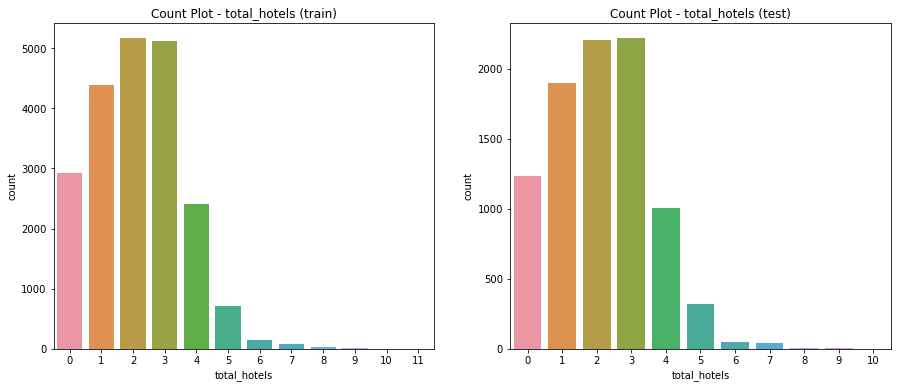

In [31]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='total_hotels', data=combined_df[:train_y.shape[0]], ax=ax[0])
sns.countplot(x='total_hotels', data=combined_df[train_y.shape[0]:], ax=ax[1])
ax[0].title.set_text('Count Plot - total_hotels (train)')
ax[1].title.set_text('Count Plot - total_hotels (test)')

### Start City

In [32]:
city_map = {
    'Mumbai': 0,
    'New Delhi': 1
}

combined_df['Start City'] = combined_df['Start City'].map(city_map)

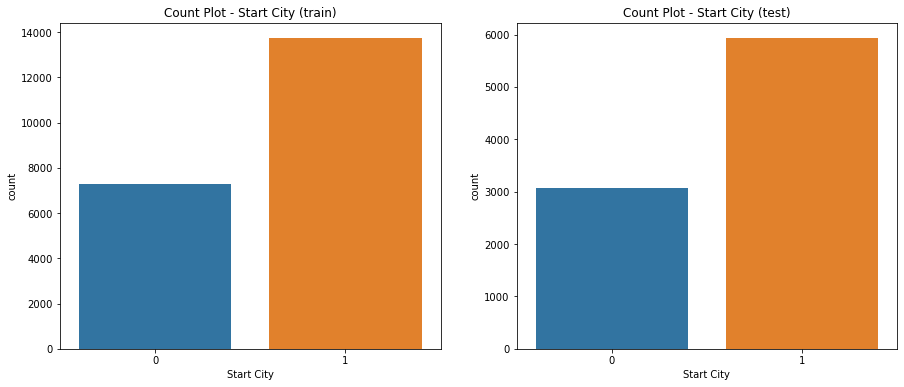

In [33]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='Start City', data=combined_df[:train_y.shape[0]], ax=ax[0])
sns.countplot(x='Start City', data=combined_df[train_y.shape[0]:], ax=ax[1])
ax[0].title.set_text('Count Plot - Start City (train)')
ax[1].title.set_text('Count Plot - Start City (test)')

### Airline

In [34]:
combined_df['Airline_Count'] = combined_df['Airline'].apply(lambda x: len(x.split('|')) if x!='Not Available' else 0)

for idx in tqdm(range(combined_df.shape[0])):
    item1 = combined_df.iloc[idx]['Airline']
    if item1 != 'Not Available':
        for item2 in item1.split('|'):
            if item2 not in combined_df.columns.to_list():
                combined_df[item2] = 0

            combined_df.loc[idx, item2] = combined_df.loc[idx, item2] + 1

print("combined_df: {}".format(combined_df.shape))
combined_df.head()

100%|██████████| 29998/29998 [02:23<00:00, 209.01it/s]

combined_df: (29998, 3966)


,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,Norwegian,British Airways,Virgin Atlantic,Turkish Airlines,Brussels Airlines,Cathay Pacific,Air Austral,South African Airways,Ethiopian Airlines,Sichuan Airlines
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,1,new delhi shimla manali chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,0,Not Available,...,0,0,0,0,0,0,0,0,0,0
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,4,srinagar pahalgam srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,1,IndiGo|IndiGo,...,0,0,0,0,0,0,0,0,0,0
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,2,udaipur chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,1,IndiGo,...,0,0,0,0,0,0,0,0,0,0
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,4,munnar kumarakom allepey kovalam and poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,1,IndiGo,...,0,0,0,0,0,0,0,0,0,0
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,4,pattaya bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,1,Spicejet|Go Air,...,0,0,0,0,0,0,0,0,0,0


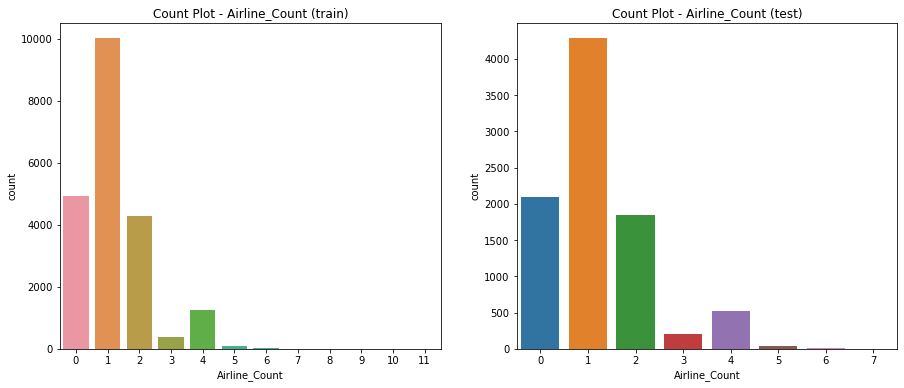

In [35]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='Airline_Count', data=combined_df[:train_y.shape[0]], ax=ax[0])
sns.countplot(x='Airline_Count', data=combined_df[train_y.shape[0]:], ax=ax[1])
ax[0].title.set_text('Count Plot - Airline_Count (train)')
ax[1].title.set_text('Count Plot - Airline_Count (test)')

### Sightseeing Places Covered

In [36]:
combined_df['Sightseeing_Count'] = combined_df['Sightseeing Places Covered'].apply(lambda x: len(x.split('|')) if x!='Not Available' else 0)

In [37]:
def process_sightseeing_place(df):
    df['Sightseeing Places Covered'] = df['Sightseeing Places Covered'].apply(lambda x: x.lower())
    df['Sightseeing Places Covered'] = df['Sightseeing Places Covered'].apply(lambda x: x.replace('\n', ' '))
    df['Sightseeing Places Covered'] = df['Sightseeing Places Covered'].str.replace('http\S+|www.\S+', '', case=False)
    df['Sightseeing Places Covered'] = df['Sightseeing Places Covered'].apply(lambda x: x.replace('&gt;', ''))
    df['Sightseeing Places Covered'] = df['Sightseeing Places Covered'].apply(remove_punctuations)
    df['Sightseeing Places Covered'] = df['Sightseeing Places Covered'].apply(lambda x: str(x).replace(" s ", " "))
    return df

In [38]:
combined_df = process_sightseeing_place(combined_df)
combined_df.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,British Airways,Virgin Atlantic,Turkish Airlines,Brussels Airlines,Cathay Pacific,Air Austral,South African Airways,Ethiopian Airlines,Sichuan Airlines,Sightseeing_Count
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,1,new delhi shimla manali chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,0,Not Available,...,0,0,0,0,0,0,0,0,0,0
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,4,srinagar pahalgam srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,1,IndiGo|IndiGo,...,0,0,0,0,0,0,0,0,0,7
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,2,udaipur chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,1,IndiGo,...,0,0,0,0,0,0,0,0,0,8
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,4,munnar kumarakom allepey kovalam and poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,1,IndiGo,...,0,0,0,0,0,0,0,0,0,9
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,4,pattaya bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,1,Spicejet|Go Air,...,0,0,0,0,0,0,0,0,0,2


In [39]:
roberta_sentence_embeddings = roberta_embedder.encode(combined_df['Sightseeing Places Covered'].values.tolist(), 
                                                      batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

In [40]:
combined_df.set_index('Uniq Id', inplace=True)
col_list = ['sightseeing_embed_'+str(i) for i in range(roberta_sentence_embeddings.shape[1])]
features_df = pd.DataFrame(roberta_sentence_embeddings, 
                           columns=col_list,
                           index=combined_df.index)
print("features_df: {}".format(features_df.shape))
combined_df = pd.merge(combined_df, features_df, 
                       on='Uniq Id', sort=False)
combined_df.reset_index(inplace=True)
combined_df.head()

features_df: (29998, 768)


,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,sightseeing_embed_758,sightseeing_embed_759,sightseeing_embed_760,sightseeing_embed_761,sightseeing_embed_762,sightseeing_embed_763,sightseeing_embed_764,sightseeing_embed_765,sightseeing_embed_766,sightseeing_embed_767
0,e788ab76d9d8cf1e6ed2f139645ca5d1,best of shimla and manali holiday from delhi,1,new delhi shimla manali chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,0,Not Available,...,0.040308,0.251682,-0.860312,0.189461,-0.360815,0.255784,-0.244736,0.570724,1.144801,-0.772336
1,178f892630ce3e335a5a41d5d83937fd,kashmir valley vacation,4,srinagar pahalgam srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,1,IndiGo|IndiGo,...,0.098356,-0.510643,-1.557686,0.182418,-0.161413,0.398704,1.380485,-1.686513,0.211284,-0.028850
2,f060f2954840503cc2fdaf495357b7df,might of mewar udaipur and chittorgarh,2,udaipur chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,1,IndiGo,...,-0.784194,-0.211278,-1.397286,0.598014,1.106841,0.505529,-0.598583,-0.562322,-0.602526,0.579293
3,32a19a6c171e67448f2346da46c619dc,colorful kerala romantic getaway,4,munnar kumarakom allepey kovalam and poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,1,IndiGo,...,-0.083332,-0.127932,-1.084767,0.067058,0.244038,0.198531,-0.176361,-1.681318,-0.157777,0.026271
4,107b068aa0ca03bc6248966f594d105f,a week in bangkok pattaya,4,pattaya bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,1,Spicejet|Go Air,...,1.009651,-0.257069,-1.534084,0.757123,0.597238,0.093345,-0.063042,-0.833701,-0.462924,0.859661


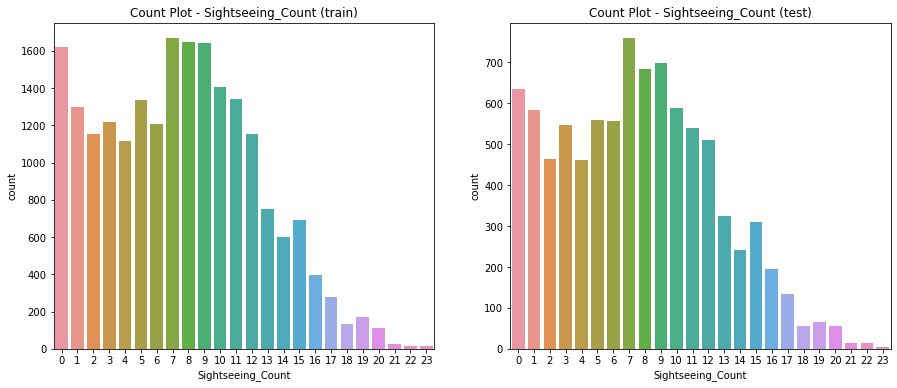

In [41]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='Sightseeing_Count', data=combined_df[:train_y.shape[0]], ax=ax[0])
sns.countplot(x='Sightseeing_Count', data=combined_df[train_y.shape[0]:], ax=ax[1])
ax[0].title.set_text('Count Plot - Sightseeing_Count (train)')
ax[1].title.set_text('Count Plot - Sightseeing_Count (test)')

### Cancellation Rules

In [42]:
cancel_rules_map = {
    'Cancellation any time after making the 1st payment instalment till the 2nd payment date:The entire amount paid as 1st payment instalment (deposit) would be non-refundable.Cancellation after 2nd payment instalment and before 3rd or final payment date:The total amount that was due at the 2nd payment instalment as per your payment schedule would be non-refundable; anything that you have paid over and above this amount would be refundable.Cancellation after 3rd or final payment date:The full amount paid by you would be non-refundable.': 0,
    "GENERAL Please note that once your booking is confirmed, you will receive an e-mail as well as an SMS on your registered mobile number confirming your booking. However, if you would like to get in touch with us please call us on 0124-4859749. We are open from 8:00 am – 8:00 pm, seven days a week Please expect to receive your vouchers 72 hours before your departure date (subject to full payment of your package cost) Please note that these packages are customizable, which means that you will be able to make changes to the itinerary/activity if you so desire. The final payment will be calculated as per the activities reflecting on the website which will be outlined in the confirmatory e-mail sent to youPersonal expenses such as laundry, telephone calls, room service, alcoholic beverages, mini bar etc., are not included In case your package needs to be cancelled due to any natural calamity, weather conditions etc. MakeMyTrip shall strive to give you the maximum possible refund subject to the agreement made with our trade partners/vendorsIf payment is not made as per the schedule provided in the first booking confirmation e-mail, MakeMyTrip reserves the right to cancel the booking after attempting to get in touch with you. Refunds would be as per the package cancellation policyFLIGHTSThe passenger names in the booking form should be exactly as per passports. MakeMyTrip will not bear any liability for the name change fee, if incorrect names and ages have been added at the time of bookingPlease note that if your package includes a flight which is a low cost carrier (Air Asia, Scoot Airlines, Air Arabia, Jetstar, Fly Dubai, Thai AirAsia, Air India Express, Tiger Airways) then baggage will not be included in the package. Baggage can be added as per your requirement at an additional cost depending on the airlines and destination. Our Travel Expert will attempt to get in touch with you within 24-hours after the booking has been confirmed for baggage additionPlease ensure that baggage requirements are given to our Travel Expert latest by 5 days before the date of departureHOTEL Standard check-in time at the hotel is normally 2:00 pm and check-out is 11:00 am. An early check-in, or a late check-out is solely based on the discretion of the hotelIn case the selected hotel is unavailable for booking, an alternate arrangement will be offered to the customer in another hotel of a similar categoryCertain hotels abroad may ask for a security deposit during check-in, which is refundable at check-out subject to the hotel’s policy  SIGHTSEEING ACTIVITIES/TRANSFERSPlease note that 'Day at Leisure' essentially implies that no sightseeing activities have been included for that day Kindly be on time for your activities, tours and transfers. Most countries are quite strict about following a schedule": 1,
    "GENERAL Please note that once your booking is confirmed, you will receive an e-mail as well as an SMS on your registered mobile number confirming your booking. However, if you would like to get in touch with us please call us on 0124-4859749. We are open from 8:00 am o?= 8:00 pm, seven days a week Please expect to receive your vouchers 72 hours before your departure date (subject to full payment of your package cost) Please note that these packages are customizable, which means that you will be able to make changes to the itinerary/activity if you so desire. The final payment will be calculated as per the activities reflecting on the website which will be outlined in the confirmatory e-mail sent to youPersonal expenses such as laundry, telephone calls, room service, alcoholic beverages, mini bar etc., are not included In case your package needs to be cancelled due to any natural calamity, weather conditions etc. MakeMyTrip shall strive to give you the maximum possible refund subject to the agreement made with our trade partners/vendorsIf payment is not made as per the schedule provided in the first booking confirmation e-mail, MakeMyTrip reserves the right to cancel the booking after attempting to get in touch with you. Refunds would be as per the package cancellation policyFLIGHTSThe passenger names in the booking form should be exactly as per passports. MakeMyTrip will not bear any liability for the name change fee, if incorrect names and ages have been added at the time of bookingPlease note that if your package includes a flight which is a low cost carrier (Air Asia, Scoot Airlines, Air Arabia, Jetstar, Fly Dubai, Thai AirAsia, Air India Express, Tiger Airways) then baggage will not be included in the package. Baggage can be added as per your requirement at an additional cost depending on the airlines and destination. Our Travel Expert will attempt to get in touch with you within 24-hours after the booking has been confirmed for baggage additionPlease ensure that baggage requirements are given to our Travel Expert latest by 5 days before the date of departureHOTEL Standard check-in time at the hotel is normally 2:00 pm and check-out is 11:00 am. An early check-in, or a late check-out is solely based on the discretion of the hotelIn case the selected hotel is unavailable for booking, an alternate arrangement will be offered to the customer in another hotel of a similar categoryCertain hotels abroad may ask for a security deposit during check-in, which is refundable at check-out subject to the hotelo?=s policy  SIGHTSEEING ACTIVITIES/TRANSFERSPlease note that Day at Leisure essentially implies that no sightseeing activities have been included for that day Kindly be on time for your activities, tours and transfers. Most countries are quite strict about following a schedule": 1,
    'If your flights involve a combination of different airlines, you may have to collect your luggage on arrival at the connecting hub and register it again while checking in for the onward journey to your destination.Booking rates are subject to change without prior notice.Pricing of the booking is based on the age of the passengers. Please make sure you enter the correct age of passengers at the time of booking. Passengers furnishing incorrect age details may incur penalty at the time of travelling.Airline seats and hotel rooms are subject to availability at the time of booking.In case of unavailability in the listed hotels, arrangement for an alternate accommodation will be made in a hotel of similar standard.A maximum of 3 adults are allowed in one room. The third occupant shall be provided a mattress/rollaway bed.The itinerary is fixed and cannot be modified. Transportation shall be provided as per the itinerary and will not be at disposal. All transfers and sightseeing shall be provided by an exclusive vehicle unless otherwise specified.Due to operational reasons, the routing of this tour may be amended. However, all mentioned services will remain unchanged.MMT reserves the right to modify the itinerary at any point, due to reasons including but not limited to: Force Majeure events, strikes, fairs, festivals, weather conditions, traffic problems, overbooking of hotels / flights, cancellation / re-routing of flights, closure of / entry restrictions at a place of visit, etc. While we will do our best to make suitable alternate arrangements, we would not be held liable for any refunds/compensation claims arising out of this.The booking price does not include: -Expenses of personal nature, such as laundry, telephone calls, room service, alcoholic beverages, mini bar charges, tips, portage, camera fees etc.-Any meals and services not specifically mentioned in the inclusions. -Any other items not mentioned under ?Inclusions? are not included in the cost of the booking.Cost of deviation and cost of extension of the validity on your ticket is not included.For queries regarding cancellations and refunds, please refer to our Cancellation Policy.Disputes, if any, shall be subject to the exclusive jurisdiction of the courts in New Delhi.': 2,
    "If your flights involve a combination of different airlines, you may have to collect your luggage on arrival at the connecting hub and register it again while checking in for the onward journey to your destination.Booking rates are subject to change without prior notice.Pricing of the booking is based on the age of the passengers. Please make sure you enter the correct age of passengers at the time of booking. Passengers furnishing incorrect age details may incur penalty at the time of travelling.Airline seats and hotel rooms are subject to availability at the time of booking.In case of unavailability in the listed hotels, arrangement for an alternate accommodation will be made in a hotel of similar standard.A maximum of 3 adults are allowed in one room. The third occupant shall be provided a mattress/rollaway bed.The itinerary is fixed and cannot be modified. Transportation shall be provided as per the itinerary and will not be at disposal. All transfers and sightseeing shall be provided by an exclusive vehicle unless otherwise specified.Due to operational reasons, the routing of this tour may be amended. However, all mentioned services will remain unchanged.MMT reserves the right to modify the itinerary at any point, due to reasons including but not limited to: Force Majeure events, strikes, fairs, festivals, weather conditions, traffic problems, overbooking of hotels / flights, cancellation / re-routing of flights, closure of / entry restrictions at a place of visit, etc. While we will do our best to make suitable alternate arrangements, we would not be held liable for any refunds/compensation claims arising out of this.The booking price does not include: -Expenses of personal nature, such as laundry, telephone calls, room service, alcoholic beverages, mini bar charges, tips, portage, camera fees etc.-Any meals and services not specifically mentioned in the inclusions. -Any other items not mentioned under ?Inclusions? are not included in the cost of the booking.Cost of deviation and cost of extension of the validity on your ticket is not included.For queries regarding cancellations and refunds, please refer to our Cancellation Policy.Disputes, if any, shall be subject to the exclusive jurisdiction of the courts in New Delhi.Package price does not include Gala dinner charges applicable on Christmas and New Year's Eve": 2,
    'Not Available': 3,
    "Package price does not include Gala dinner charges applicable on Christmas and New Year's Eve": 4,
    "This cancellation policy is applicable for bookings made for Weekend Getaways through the MakeMyTrip platform   If the booking is made 15 days prior to the travel date (i.e. the date on which the customer is travelling):  When the customer has booked a weekend getaway 15 days (inclusive of the travel date) prior to the travel date, the customer is eligible to avail the benefit of this offer.At the time of making the payment while booking the package, the customer shall have the option of either paying in total or in instalments. If the customer chooses to make the payment in total and cancels the booking within 24 hours of making the payment, the customer shall be entitled to get the full refund under this offer. In case of any flight bookings, MakeMyTrip shall, in its sole discretion, refund partial booking amount to the customer. Full refund under the offer is not applicable on Air Asia, Scoot Airlines, Nok-Scoot and Tiger Australia.  If a customer chooses to make the payment in instalments and cancels the booking thereafter, MakeMyTrip shall provide the refund in the following manner:When the customer has made 1st instalment of the booking amount and the booking is cancelled within 24 hours of making the booking, MakeMyTrip shall refund the full amount paid in the 1st instalment. However, In case of any flight bookings, MakeMyTrip shall, in its sole discretion, refund partial booking amount to the customer. Full refund under the offer is not applicable on Air Asia, Scoot Airlines, Nok-Scoot & Tiger Australia.  When the customer has made 1st instalment of the booking amount and the booking is cancelled after 24 hours of making the booking but before making the 2nd instalment, the entire 1st instalment shall be non-refundable.  When the customer cancels the booking upon paying the 2nd instalment but before paying the 3rd instalment, the amount of 1st and 2nd instalment as paid by the customer shall be non-refundable. However, if the customer has paid an amount over and above the amount to be paid for the 1st and 2nd instalment, MakeMyTrip shall refund the said amount.  When the customer cancels the booking upon paying the 3rd instalment, the entire booking amount paid shall be non-refundable.  If the booking is made within 15 days from the travel date:   When the customer has made 1st instalment of the booking amount and the booking is cancelled before making the 2nd instalment, the entire 1st instalment shall be non-refundable.  When the customer cancels the booking upon paying the 2nd instalment but before paying the 3rd instalment, the amount of 1st and 2nd instalment as paid by the customer shall be non-refundable. However, if the customer has paid an amount over and above the amount to be paid for the 1st and 2nd instalment, MakeMyTrip shall refund the said amount.When the customer cancels the booking upon paying the 3rd instalment, the entire booking amount paid shall be non-refundable.": 5
}

combined_df['Cancellation Rules'] = combined_df['Cancellation Rules'].map(cancel_rules_map)

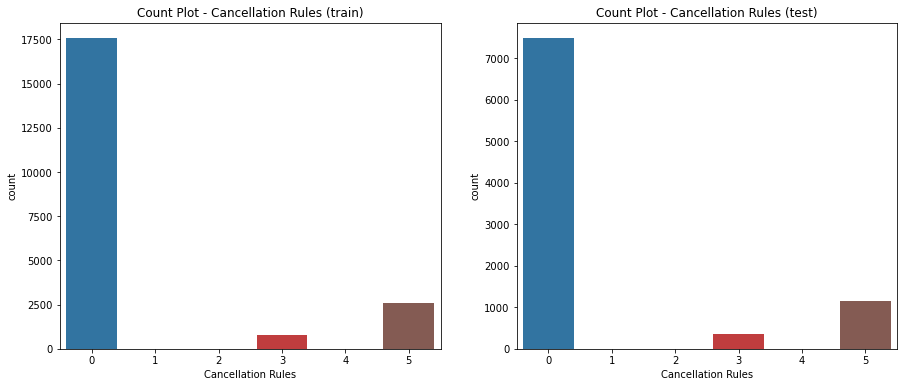

In [43]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='Cancellation Rules', data=combined_df[:train_y.shape[0]], ax=ax[0])
sns.countplot(x='Cancellation Rules', data=combined_df[train_y.shape[0]:], ax=ax[1])
ax[0].title.set_text('Count Plot - Cancellation Rules (train)')
ax[1].title.set_text('Count Plot - Cancellation Rules (test)')

### Drop redundant columns

In [44]:
combined_df.drop(['Package Name','Package Type','Destination','Itinerary',
                  'Places Covered','Travel Date','Hotel Details','Start City',
                  'Airline','Sightseeing Places Covered','Cancellation Rules',
                  'hotels_list'], 
                 axis=1, inplace=True)
combined_df.head()

,Uniq Id,Flight Stops,Meals,pkg_embed_0,pkg_embed_1,pkg_embed_2,pkg_embed_3,pkg_embed_4,pkg_embed_5,pkg_embed_6,...,sightseeing_embed_758,sightseeing_embed_759,sightseeing_embed_760,sightseeing_embed_761,sightseeing_embed_762,sightseeing_embed_763,sightseeing_embed_764,sightseeing_embed_765,sightseeing_embed_766,sightseeing_embed_767
0,e788ab76d9d8cf1e6ed2f139645ca5d1,2,3,0.371670,-0.206987,-0.269378,0.853215,1.360289,0.325030,-0.545870,...,0.040308,0.251682,-0.860312,0.189461,-0.360815,0.255784,-0.244736,0.570724,1.144801,-0.772336
1,178f892630ce3e335a5a41d5d83937fd,0,5,-0.118339,0.130931,-0.564064,0.075900,1.223229,0.598444,-0.654406,...,0.098356,-0.510643,-1.557686,0.182418,-0.161413,0.398704,1.380485,-1.686513,0.211284,-0.028850
2,f060f2954840503cc2fdaf495357b7df,0,4,-0.431784,-0.424429,-0.620854,0.469178,0.477869,0.008921,0.341752,...,-0.784194,-0.211278,-1.397286,0.598014,1.106841,0.505529,-0.598583,-0.562322,-0.602526,0.579293
3,32a19a6c171e67448f2346da46c619dc,0,5,-0.082662,0.457761,-0.569400,0.568781,0.231802,1.135896,-0.269390,...,-0.083332,-0.127932,-1.084767,0.067058,0.244038,0.198531,-0.176361,-1.681318,-0.157777,0.026271
4,107b068aa0ca03bc6248966f594d105f,0,5,0.475992,-0.889012,-0.436457,0.108763,-0.258765,-0.134426,-0.356701,...,1.009651,-0.257069,-1.534084,0.757123,0.597238,0.093345,-0.063042,-0.833701,-0.462924,0.859661


### Additional features

In [45]:
combined_df['meals_per_flight_stops'] = combined_df.apply(lambda row: 0 if row['Flight Stops']==0 else row['Meals']/row['Flight Stops'], axis=1)
combined_df['destination_per_day'] = combined_df['Destination_Count']/combined_df['total_days']
combined_df['sightseeing_per_day'] = combined_df['Sightseeing_Count']/combined_df['total_days']
combined_df['hotels_per_day'] = combined_df['total_hotels']/combined_df['total_days']
combined_df['airline_per_destination'] = combined_df['Airline_Count']/combined_df['Destination_Count']
combined_df['sightseeing_per_destination'] = combined_df['Sightseeing_Count']/combined_df['Destination_Count']

In [46]:
combined_df[combined_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,Uniq Id,Flight Stops,Meals,pkg_embed_0,pkg_embed_1,pkg_embed_2,pkg_embed_3,pkg_embed_4,pkg_embed_5,pkg_embed_6,...,sightseeing_embed_764,sightseeing_embed_765,sightseeing_embed_766,sightseeing_embed_767,meals_per_flight_stops,destination_per_day,sightseeing_per_day,hotels_per_day,airline_per_destination,sightseeing_per_destination


### Segregate train/test datasets

In [47]:
train_df = combined_df[:train_y.shape[0]].copy()
test_df = combined_df[train_y.shape[0]:].copy()
train_df.set_index('Uniq Id', inplace=True)
test_df.set_index('Uniq Id', inplace=True)
print("train_df: {} \ntest_df: {}".format(train_df.shape, test_df.shape))

train_df: (20998, 4728) 
test_df: (9000, 4728)


In [48]:
for col in tqdm(train_df.columns):
    transformer = QuantileTransformer(n_quantiles=1000, 
                                      random_state=10, 
                                      output_distribution="normal")
    
    vec_len = len(train_df[col].values)
    vec_len_test = len(test_df[col].values)

    raw_vec = train_df[col].values.reshape(vec_len, 1)
    test_vec = test_df[col].values.reshape(vec_len_test, 1)
    transformer.fit(raw_vec)
    
    train_df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_df[col] = transformer.transform(test_vec).reshape(1, vec_len_test)[0]

100%|██████████| 4728/4728 [00:58<00:00, 81.11it/s]


In [49]:
train_df['Per Person Price'] = train_y.ravel()
train_df.head()

,Flight Stops,Meals,pkg_embed_0,pkg_embed_1,pkg_embed_2,pkg_embed_3,pkg_embed_4,pkg_embed_5,pkg_embed_6,pkg_embed_7,...,sightseeing_embed_765,sightseeing_embed_766,sightseeing_embed_767,meals_per_flight_stops,destination_per_day,sightseeing_per_day,hotels_per_day,airline_per_destination,sightseeing_per_destination,Per Person Price
Uniq Id,,,,,,,,,,,,,,,,,,,,,
e788ab76d9d8cf1e6ed2f139645ca5d1,5.199338,-0.523537,0.525330,-0.041413,0.325577,0.664287,1.159515,0.216204,-0.918498,0.932184,...,1.824556,5.199337,-1.811457,0.199538,0.744694,-5.199338,-5.199338,-5.199338,-5.199338,9.350972
178f892630ce3e335a5a41d5d83937fd,-5.199338,5.199338,-0.555065,0.878430,-0.381567,-0.590949,0.907080,0.599936,-1.132444,-0.942439,...,-0.493553,0.756333,-0.383024,-5.199338,1.192071,0.166367,0.081638,0.533636,-0.293986,10.020670
f060f2954840503cc2fdaf495357b7df,-5.199338,0.401995,-1.275303,-0.602943,-0.552537,0.023839,-0.121995,-0.185480,0.844485,0.295512,...,1.023003,-1.625274,1.149742,-5.199338,0.744694,0.981540,0.949547,0.205941,0.558392,9.427265
32a19a6c171e67448f2346da46c619dc,-5.199338,5.199338,-0.455640,1.773922,-0.396947,0.200818,-0.464007,1.418118,-0.357496,-0.869846,...,-0.475214,-0.244757,-0.224329,-5.199338,0.744694,-0.085414,0.949547,-0.524976,-0.358833,10.490385
107b068aa0ca03bc6248966f594d105f,-5.199338,5.199338,0.738089,-1.861434,-0.076604,-0.535539,-0.973443,-0.387078,-0.529301,0.728240,...,0.778225,-1.236652,1.554269,-5.199338,-1.456896,-1.283836,-0.816150,0.908975,-1.031509,10.149762


### Save the processed datasets

In [50]:
data_dict = {}
data_dict['train_df'] = train_df
data_dict['test_df'] = test_df

file = open("./Workation_Dataset.txt", 'wb')
pickle.dump(data_dict, file)
file.close()